# Combining data from EU CRM and GEA OekoRess II studies 

### Merging the parameters for the waste stream model

Economical Importance, Supply Risk, and End-of-Life Recycling input rate from EU CRM study

aEHP, EGov and GSMEF from GEA OekoRess II

In [14]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)

In [9]:
eol = pd.read_csv('../CRM data/eol-rir_data.csv', sep=',')
sr_ei = pd.read_csv('../CRM data/sr_ei_data.csv', sep=',')
data = pd.read_csv('../CRM data/full_data.csv', sep=',')
#data.drop(columns=['Unnamed: 0'],inplace=True)

epi = pd.read_csv('../CRM data/epi_num.csv',sep=',')


Merging Economical Importance and Supply risk, with End-of-Life Recycling input rate data

In [2]:
#data = pd.merge(eol,sr_ei)
#data['EOLR'] = data['EOLR']/100
#data.to_csv('../CRM data/full_data.csv',index=False)


Converting Environmental impact (OekoRess II) data to numerical, from 0 to 1

In [71]:
# Convert epi values l,m,h to numeric
#num = {'l':0.00,'l-m':0.25,'m':0.5,'m-h':0.75,'h':1.0}
#epi = epi.applymap(lambda x: num[x] if x in num else x)
#epi.to_csv('../CRM data/epi_num.csv',index=False)


In [83]:
# Find duplicates in data
#duplicates = eol[eol['Material'].duplicated(keep=False)]

Merging CRM data Env. impact data, left join on Env.impact elements (in total 30 elements)
 
CRM data contains 72 elements

In [85]:
# Find differences between 2 columns in 2 different df

# Find names in epi, that's not EU CRM
diff_epi = set(epi['Material'])-set(data['Material'])
diff_data_epi = set(data['Material'])-set(epi['Material'])


#compData = pd.merge(epi,data,how='inner')
#compData.to_csv('../CRM data/compData.csv',index=False)

Testing some clustering

In [11]:
critical = data[(data['SR']>=1.0) &(data['EI']>=1.0)]
#critical = data


In [12]:
critical = critical[['Material','EOLR','SR','EI']]
norms = critical[['Material','EOLR','SR','EI']]

In [21]:
scaler = MinMaxScaler()

In [16]:
numerical_cols = ['EOLR','SR','EI']

In [17]:
norms[numerical_cols] = scaler.fit_transform(norms[numerical_cols])

In [18]:
TOcluster = norms[numerical_cols]

In [19]:
dbscan = DBSCAN(eps=0.25, min_samples=3)
norms['Cluster'] = dbscan.fit_predict(TOcluster)

#print(norms[['Material','Cluster']])

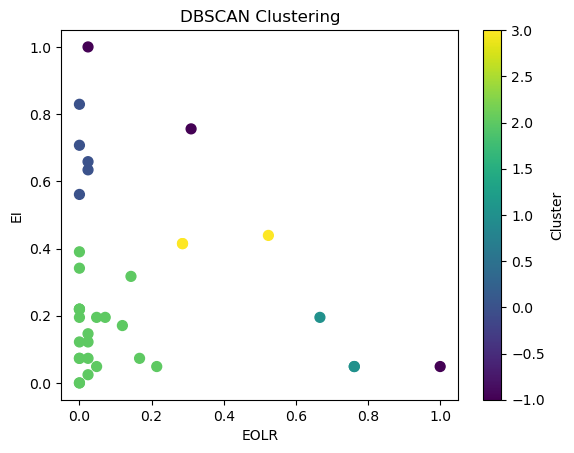

In [20]:
# Visualize (if 2D or 3D data)
plt.scatter(norms['EOLR'], norms['SR'], c=norms['Cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('EOLR')
plt.ylabel('EI')
plt.colorbar(label='Cluster')
plt.show()

In [31]:
#critical[norms['Cluster']==0]

In [17]:
# Criticality factor
critical['Criticality'] = (critical['EOLR'])+critical['SR']+((critical['EI']))

In [18]:
criticality_sorted = critical.sort_values(by=['Criticality'], axis=0, ascending=False, inplace=False, kind='quicksort')

In [19]:
# Data for Iron-Based Alloys
iron_alloys_data = {
    "Alloy": ["High-Speed Steel (M2)", "Maraging Steel (Grade 300)", "Tungsten Steel"],
    "Iron": [70, 75, 70],
    "Nickel": [0, 18, 0],
    "Tungsten": [6, 0, 25],
    "Cobalt": [8, 9, 5],
    "Chromium": [4, 0, 0],
    "Vanadium": [2, 0, 0],
    "Titanium": [0, 0.6, 0],
    "Molybdenum": [5, 0.3, 0],
    "Carbon": [1, 0, 0],
}

# Data for Aluminum-Based Alloys
aluminum_alloys_data = {
    "Alloy": ["6061 Aluminum", "Al-Li 2090", "7055 Aluminum"],
    "Aluminium": [97, 90, 91],
    "Magnesium": [1, 0.3, 2],
    "Silicon": [0.6, 0, 0],
    "Copper": [0.3, 2.7, 2],
    "Chromium": [0.2, 0, 0],
    "Lithium": [0, 2.5, 0],
    "Zirconium": [0, 0.1, 0],
    "Zinc": [0, 0, 8],
    "Titanium": [0, 0, 0.2],
}

# Data for Nickel-Based Alloys
nickel_alloys_data = {
    "Alloy": ["Inconel 718"],
    "Nickel": [52],
    "Iron": [18],
    "Chromium": [19],
    "Molybdenum": [3],
    "Niobium": [5],
    "Titanium": [1],
    "Cobalt": [1],
}

# Data for Titanium-Based Alloys
titanium_alloys_data = {
    "Alloy": ["Ti-6Al-4V", "Ti-10V-2Fe-3Al"],
    "Titanium": [89, 86],
    "Aluminum": [6, 3],
    "Vanadium": [4, 10],
    "Iron": [0.25, 2],
}

# Convert to DataFrames
iron_alloys_df = pd.DataFrame(iron_alloys_data).fillna(0).T
aluminium_alloys_df = pd.DataFrame(aluminum_alloys_data).fillna(0).T
nickel_alloys_df = pd.DataFrame(nickel_alloys_data).fillna(0).T
titanium_alloys_df = pd.DataFrame(titanium_alloys_data).fillna(0).T

In [20]:
nickel_alloys_df

,0
Alloy,Inconel 718
Nickel,52
Iron,18
Chromium,19
Molybdenum,3
Niobium,5
Titanium,1
Cobalt,1


In [21]:
M2 = iron_alloys_df.iloc[1:,0]
G300 = iron_alloys_df.iloc[1:,1]
Tungs = iron_alloys_df.iloc[1:,2]

inconel = nickel_alloys_df.iloc[1:,0]

In [22]:
# Merge alloy and it's material params

def merge_alloy_data(material_df,alloy):
    merged_d = pd.merge(material_df,alloy.rename("Composition"), 
                    left_on="Material", 
                    right_index=True, 
                    how="inner")
    return merged_d.astype({'Composition':'float64'})


    

In [23]:
G300_merge = merge_alloy_data(critical,G300)
M2_merge = merge_alloy_data(critical,M2)
inco_merge = merge_alloy_data(critical,inconel)

In [24]:
G300_merge

,Material,EOLR,SR,EI,Criticality,Composition
33,Chromium,0.21,0.7,7.2,8.11,0.0
36,Cobalt,0.22,2.8,6.8,9.82,9.0
40,Molybdenum,0.30,0.8,6.7,7.80,0.3
50,Titanium,0.01,0.5,5.4,5.91,0.6
57,Nickel,0.16,0.5,5.7,6.36,18.0
58,Tungsten,0.42,1.2,8.7,10.32,0.0
61,Vanadium,0.06,2.3,3.9,6.26,0.0


In [25]:
def calculate_weighted_params(df):
    df = df[df['Composition']>0]
    df_ei = df['EI']*df['Criticality']*((df['Composition'])/100)
    df_sr = df['SR']*df['Criticality']*(df['Composition']/100)
    df_eol = df['EOLR']*df['Criticality']*(df['Composition']/100)
    return df_eol.sum().round(3), df_sr.sum().round(3), df_ei.sum().round(3)

In [26]:
G300composite = calculate_weighted_params(G300_merge)
M2composite = calculate_weighted_params(M2_merge)
incocomposite = calculate_weighted_params(inco_merge)

In [27]:
G300composite

(0.385, 3.083, 12.883)

In [28]:
M2composite

(0.626, 3.77, 16.166)

In [29]:
M2_merge

,Material,EOLR,SR,EI,Criticality,Composition
33,Chromium,0.21,0.7,7.2,8.11,4.0
36,Cobalt,0.22,2.8,6.8,9.82,8.0
40,Molybdenum,0.30,0.8,6.7,7.80,5.0
50,Titanium,0.01,0.5,5.4,5.91,0.0
57,Nickel,0.16,0.5,5.7,6.36,0.0
58,Tungsten,0.42,1.2,8.7,10.32,6.0
61,Vanadium,0.06,2.3,3.9,6.26,2.0


In [30]:
G300_merge

,Material,EOLR,SR,EI,Criticality,Composition
33,Chromium,0.21,0.7,7.2,8.11,0.0
36,Cobalt,0.22,2.8,6.8,9.82,9.0
40,Molybdenum,0.30,0.8,6.7,7.80,0.3
50,Titanium,0.01,0.5,5.4,5.91,0.6
57,Nickel,0.16,0.5,5.7,6.36,18.0
58,Tungsten,0.42,1.2,8.7,10.32,0.0
61,Vanadium,0.06,2.3,3.9,6.26,0.0
